# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.11.0  Device: cpu


## 3. CIFAR10 데이터 다운로드 (Train data와 Test data 분리하기)

In [18]:
BATCH_SIZE = 32 

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
print(list(train_loader)[1])
# print(test_data)

[tensor([[[[0.1961, 0.2000, 0.1647,  ..., 0.1882, 0.0706, 0.0549],
          [0.3373, 0.3608, 0.3216,  ..., 0.1804, 0.0667, 0.0431],
          [0.1686, 0.1686, 0.2000,  ..., 0.1647, 0.0392, 0.0235],
          ...,
          [0.8627, 0.8196, 0.7804,  ..., 0.6941, 0.6902, 0.6863],
          [0.7373, 0.7137, 0.7137,  ..., 0.6902, 0.6863, 0.6824],
          [0.7373, 0.7216, 0.7294,  ..., 0.6902, 0.6902, 0.6784]],

         [[0.2510, 0.2471, 0.2157,  ..., 0.1765, 0.0706, 0.0588],
          [0.4196, 0.4314, 0.3882,  ..., 0.1686, 0.0667, 0.0471],
          [0.2353, 0.2196, 0.2549,  ..., 0.1529, 0.0392, 0.0235],
          ...,
          [0.6471, 0.6824, 0.6745,  ..., 0.6706, 0.6667, 0.6588],
          [0.6980, 0.6667, 0.6314,  ..., 0.6588, 0.6549, 0.6510],
          [0.6549, 0.6392, 0.6549,  ..., 0.6627, 0.6588, 0.6471]],

         [[0.1451, 0.1608, 0.1608,  ..., 0.1647, 0.0549, 0.0471],
          [0.2627, 0.2980, 0.2627,  ..., 0.1608, 0.0549, 0.0392],
          [0.1647, 0.1608, 0.1804,  ..., 

## 4. 첫번째 batch 데이터의 크기와 타입을 확인하기

In [29]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


## 4. torch.nn을 이용하여 모델 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!


In [55]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3072,100)
        self.fc2 = nn.Linear(100,10)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

## 5. 초기화를 위한 함수 만들기

In [56]:
def init_constants(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight.data, 0)
        nn.init.constant_(m.bias.data, 0)
        
def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0)
        nn.init.normal_(m.bias.data, 0)

def init_xaiver(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        
def init_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

## 6. 모델 객체 만들고 다르게 초기화 하기

In [57]:
########## 아래 채우시오에 함수명을 적으면됩니다.

network_const = Model()
network_const.apply(init_constants)

network_normal = Model()
network_normal.apply(init_normal)

network_xaiver = Model()
network_xaiver.apply(init_xaiver)

network_kaiming = Model()
network_kaiming.apply(init_kaiming)

Model(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [1]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()

        # 이미지를 (batch_size, 784) 차원의 메트릭스로 만드세요
        batch_size = image.size()[0]
        image = image.view(-1, 32 * 32 * 3)

        # Forward propagration 계산하기.
        outputs = network(image)
        
        
        # Cross_entropy 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = torch.max(outputs,1)[1]
        train_correct += pred.eq(label).sum()

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

In [72]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size()[0]
            image = image.view(-1, 32 * 32 * 3)

            # Forward propagration 계산하기.
            outputs = network(image)

            # Cross_entropy 함수를 적용하여 loss를 구하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = torch.max(outputs,1)[1]
            correct += pred.eq(label).sum()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

In [73]:
def training(network):
    
    learning_rate = 0.01
    epoches = 20
    
    cls_loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr = learning_rate)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_loader, network, cls_loss, optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [74]:
rlt_const = training( network_const)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.303894
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.302013
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.301397

Training set: Accuracy: 4746/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303896
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.302014
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.301397

Training set: Accuracy: 4745/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.303897
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.302014
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.301397

Training set: Accuracy: 4745/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.303897
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.302014
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 3 [48000/50000 (96%)

In [75]:
rlt_normal = training(network_normal)

Train Epoch: 0 [0/50000 (0%)]	Loss: 295.889404
Train Epoch: 0 [16000/50000 (32%)]	Loss: 6.326255
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.171260
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.777370

Training set: Accuracy: 8666/50000 (17%)
Test set: Accuracy: 1863/10000 (19%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 3.837421
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.425745
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.986106
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.340611

Training set: Accuracy: 9654/50000 (19%)
Test set: Accuracy: 2000/10000 (20%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 3.387669
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.097684
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.958185
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.288341

Training set: Accuracy: 10241/50000 (20%)
Test set: Accuracy: 2075/10000 (21%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 3.163747
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.987638
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.946238
Train Epoch: 3 [48000/50000

In [76]:
rlt_xaiver = training(network_xaiver)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.510478
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.926545
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.838859
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.151284

Training set: Accuracy: 16223/50000 (32%)
Test set: Accuracy: 3775/10000 (38%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.812534
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.677950
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.744180
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.144619

Training set: Accuracy: 19841/50000 (40%)
Test set: Accuracy: 3969/10000 (40%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.820287
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.566140
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.683372
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.135158

Training set: Accuracy: 21051/50000 (42%)
Test set: Accuracy: 4042/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.803869
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.503126
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.641379
Train Epoch: 3 [48000/50000

In [77]:
rlt_kaiming = training(network_kaiming)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.533798
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.842505
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.808467
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.203779

Training set: Accuracy: 16149/50000 (32%)
Test set: Accuracy: 3555/10000 (36%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.748080
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.619747
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.716978
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.160637

Training set: Accuracy: 19588/50000 (39%)
Test set: Accuracy: 3923/10000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.712167
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.521300
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.656055
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.095718

Training set: Accuracy: 21036/50000 (42%)
Test set: Accuracy: 3990/10000 (40%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.738149
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.479507
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.603978
Train Epoch: 3 [48000/50000

# 학습 결과 보기 
## 1. loss 값 비교

In [78]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

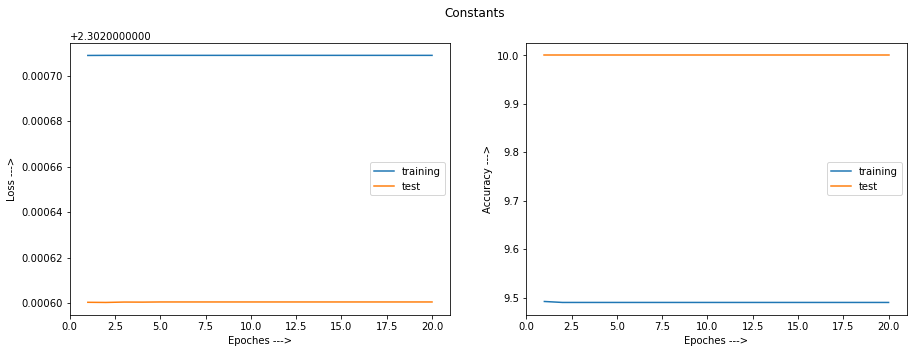

In [79]:
show_rlt(rlt_const, 'Constants')

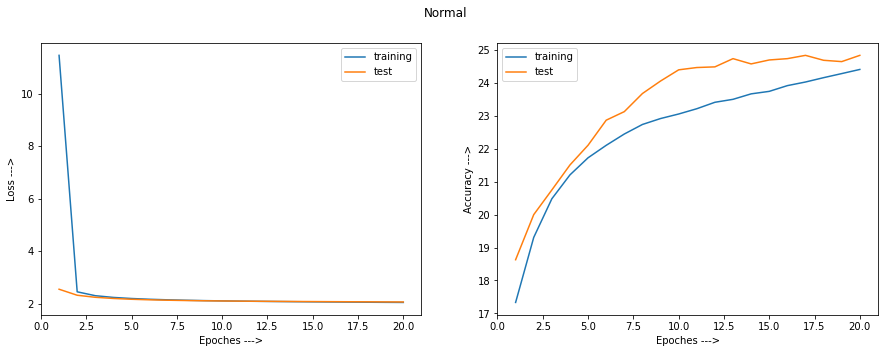

In [80]:
show_rlt(rlt_normal, 'Normal')

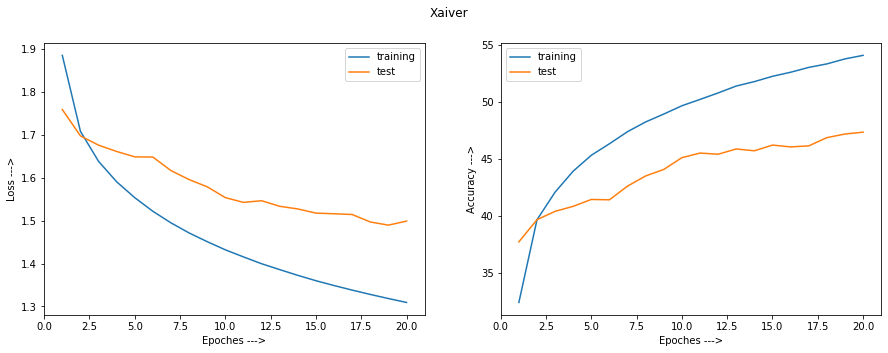

In [81]:
show_rlt(rlt_xaiver, 'Xaiver')

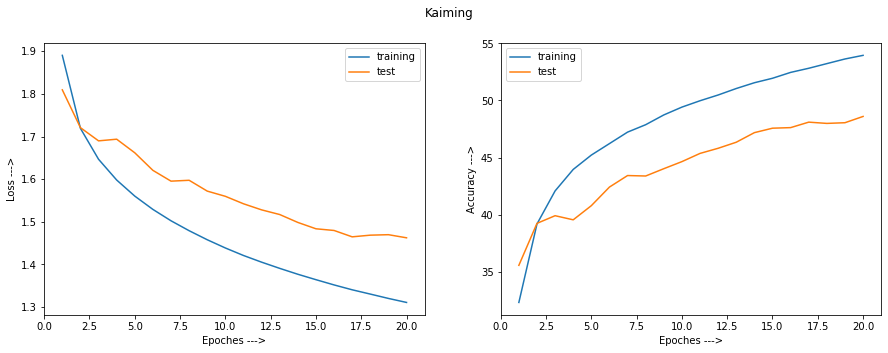

In [82]:
show_rlt(rlt_kaiming, 'Kaiming')

## 2. 위 4개의 초기화 방법를 비교하고 성능에 대해서 분석하시오

정답) 위의 그래프를 보면 xavier와 kaiming의 성능이 가장 높고, constant가 가장 낮음을 알 수 있다. constant의 경우 학습이 진행되어도 loss값의 변화가 없어 정확도가 정체되어 있음을 확인할 수 있고, 그 정확도가 10% 정도 수준이어서 매우 낮다는 사실을 확인할 수 있다.Normal의 경우 constant 보다는 높은 정확도를 보이지만, loss 값이 2에 수렴하면서 정확도도 25%에서 더 향상되지 않는 것을 확인할 수 있다. 반면 xavier와 kaiming의 경우 학습이 진행되면서 loss 값이 지속적으로 감소하고, 학습이 더 진행되면 더 높은 정확도를 보여줄 것으로 예상된다. 